## Self supervised large scale generalisation - Affables 

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
s3_prefixes = []
for (t,p, m) in [(2000, 500, 0), (4000,1000,2000), (6000,1500, 4000), (8000,2000,6000), (10000,2500,8000)]:
    for i in ["00", "01", "02", "03", "04"]:
        s3_prefixes.append(f"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-{t}-{p}-{m}-bert-f1-{i}-202212231935/202212262038/")


In [3]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [4]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [5]:
import shutil
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)

    


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        

In [6]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]

def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       ).astype(str)
    
    
    return df

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred,labels=["False", "True"], normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =  ["False", "True"])
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [8]:


def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in sorted(os.listdir(local_temp_pred_dir)):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        df=df.pipe(self_label)
        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id", "self_label"]])

 
    return  pd.concat(list_df_summary)




In [9]:
%%time 

from sklearn.metrics import precision_recall_fscore_support
import regex as re
import io, sagemaker

def create_stats_df(s3_prefix, confidence=0.0):
    print(f"Running {s3_prefix}, confidence {confidence}")

    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)
    df = get_summary_df (local_temp_pred_dir)


    total_predictions= len(df)
    df = df.query(f"confidence > {confidence} ")

    name = s3_prefix
    r = re.search(  "predictions_selfsup-affablesposnegs-(\d+)-(\d+)-(\d+)", s3_prefix)
    name= s3_prefix
    train_size= int(r.group(1))
    train_pos_size= int(r.group(2))
    train_affable=  int(r.group(3))
    prediction_above_threshold = len(df)

    p,r,f,s = precision_recall_fscore_support(df["self_label"], 
                         df["prediction"], pos_label = "True", average="binary", zero_division=0)
        
    return { "Name": name, 
                    "Precision":p*100,
                    "Recall":r*100,
                    "F1":f*100,  
                  #  "Threshold": "HighConfidence", 
                    "Support": s, 
                        "TrainSize":train_size, "TrainSizePositive": train_pos_size,
                        "TrainAffable" : train_affable,
                        "TrainAffableRate" : train_affable/train_size,
                        "PredictionsSize": total_predictions, 
                   "PredictionsAboveThresholdSize": prediction_above_threshold,
                    "PredictionsAboveThresholdRatio" :prediction_above_threshold/total_predictions
           
           }
    
    

def create_stats_dfs_from_prefixes(s3_prefixes):
    result = [ create_stats_df(s, confidence=0.0) for s in s3_prefixes]
    df =  pd.DataFrame(result)
    return df

df_stats = create_stats_dfs_from_prefixes(s3_prefixes)

Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-00-202212231935/202212262038/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-01-202212231935/202212262038/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-02-202212231935/202212262038/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-03-202212231935/202212262038/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-2000-500-0-bert-f1-04-202212231935/202212262038/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-4000-1000-2000-bert-f1-00-202212231935/202212262038/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsup-affablesposnegs-4000

No handles with labels found to put in legend.


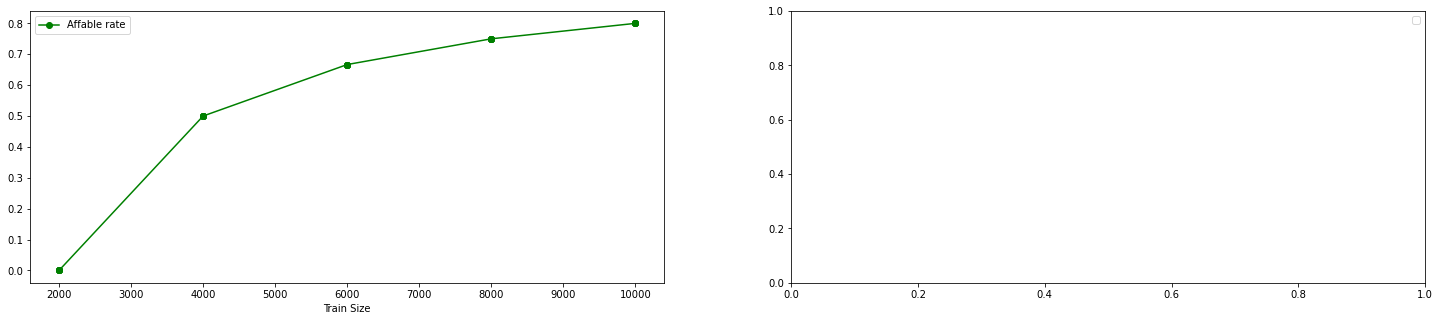

In [10]:
import warnings, matplotlib.pyplot as plt

def plot_comparison(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,2, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainAffableRate" : "Affable rate" ,
                        "TrainSize": "Train Size",
                        "Recall" : "Recall" , 
                        "F1": "F1" , 
                       }

        df[["TrainSize", "TrainAffableRate"]]\
            .rename(columns=column_renames)\
            .plot(x="Train Size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))

       
        plt.legend()

plot_comparison(df_stats)   

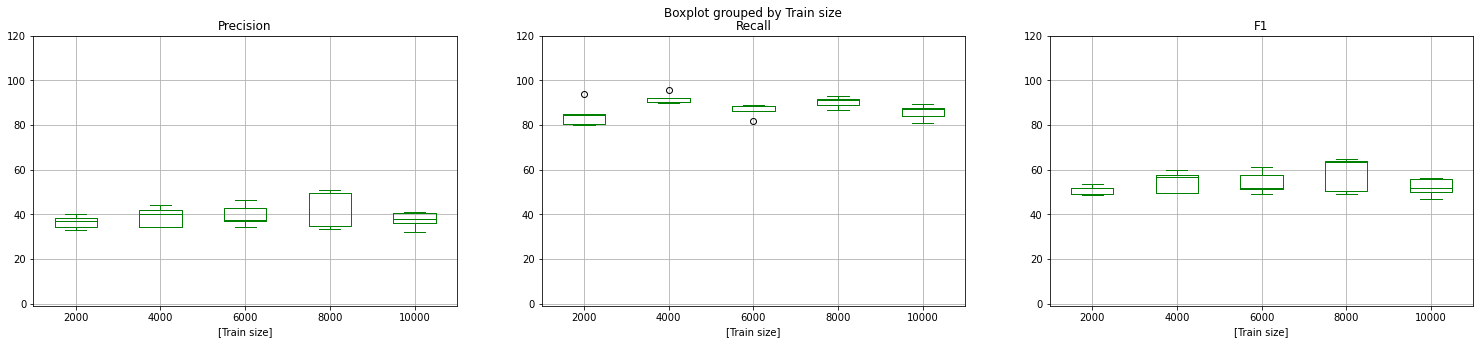

In [11]:
def plot_comparison_box(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAffableRate" : "Affable rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-1,120)
        df[["Precision", "TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[0], color="green")

        ax[1].set_ylim(-1,120)
        df[["Recall","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[1], color="green")

        ax[2].set_ylim(-1,120)
        df[["F1","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[2], color="green")


#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_box(df_stats)

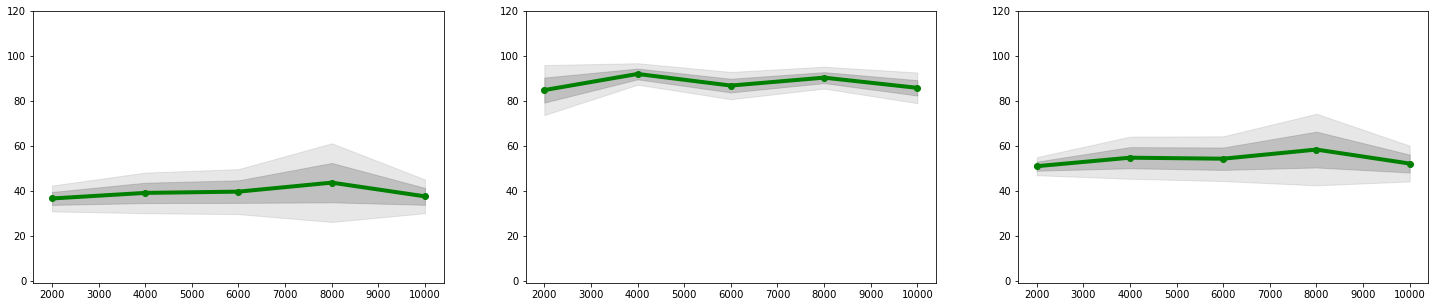

In [12]:
def plot_stdline(x, y_mean, y_std, ax, label):
    ax.plot(x, y_mean, color='green', label=label, linewidth = 4.0, marker='o')
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color='#888888', alpha=0.4)
    ax.fill_between(x, y_mean - 2*y_std, y_mean + 2*y_std, color='#888888', alpha=0.2)



def plot_comparison_linestd(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAffableRate" : "Affable rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-1,120)
        ldf = df.groupby("TrainSize")["Precision"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[0],  label='Precision')
       

        ax[1].set_ylim(-1,120)
        ldf = df.groupby("TrainSize")["Recall"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[1],  label='Recall')


        ax[2].set_ylim(-1,120)
        ldf = df.groupby("TrainSize")["F1"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[2],  label='F1')

        



#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_linestd(df_stats)

In [13]:
df_stats.groupby("TrainSize")[["Precision", "Recall", "F1"]].describe()



Precision                                                        \
              count       mean       std        min        25%        50%   
TrainSize                                                                   
2000            5.0  36.542432  2.873982  32.876633  34.440035  37.112074   
4000            5.0  39.024477  4.518939  34.263931  34.408483  40.109339   
6000            5.0  39.585994  5.008098  34.145641  36.859020  37.472986   
8000            5.0  43.590890  8.755065  33.425026  34.633765  49.328043   
10000           5.0  37.478771  3.750285  31.879829  36.099930  37.681617   

                                Recall             ...                        \
                 75%        max  count       mean  ...        75%        max   
TrainSize                                          ...                         
2000       38.321964  39.961453    5.0  84.794311  ...  85.045686  93.852069   
4000       42.131048  44.209584    5.0  91.973374  ...  92.086658  95.853144   
6000       42.996579  46.455743    5.0  86.799520  ...  88.518626  89.118121   
8000       49.771659  50.795955    5.0  90.335304  ...  91.685616  92.822591   
10000      40.770885  40.961593    5.0  85.793195  ...  87.815769  89.291768   

             F1                                                        \
          count       mean       std        min        25%        50%   
TrainSize                                                               
2000        5.0  50.907823  2.002778  48.695204  49.026384  51.591024   
4000        5.0  54.697457  4.690527  49.650350  49.766516  56.553928   
6000        5.0  54.247230  4.976987  49.281267  51.384899  51.656170   
8000        5.0  58.314919  7.969743  48.954068  50.276024  63.456801   
10000       5.0  52.088137  3.983333  46.686447  49.910013  51.996564   

                                 
                 75%        max  
TrainSize                        
2000       51.799236  53.427267  
4000       57.812155  59.704338  
6000       57.839382  61.074434  
8000       64.089376  64.798326  
10000      55.687375  56.160287  

[5 rows x 24 columns]

In [14]:
df_stats

,Name,Precision,Recall,F1,Support,TrainSize,TrainSizePositive,TrainAffable,TrainAffableRate,PredictionsSize,PredictionsAboveThresholdSize,PredictionsAboveThresholdRatio
0,s3://aegovan-data/selfsupervised_chemprot/pred...,38.321964,79.898292,51.799236,None,2000,500,0,0.000000,500819,500819,1.0
1,s3://aegovan-data/selfsupervised_chemprot/pred...,32.876633,93.852069,48.695204,None,2000,500,0,0.000000,500819,500819,1.0
2,s3://aegovan-data/selfsupervised_chemprot/pred...,37.112074,84.595030,51.591024,None,2000,500,0,0.000000,500819,500819,1.0
3,s3://aegovan-data/selfsupervised_chemprot/pred...,34.440035,85.045686,49.026384,None,2000,500,0,0.000000,500819,500819,1.0
4,s3://aegovan-data/selfsupervised_chemprot/pred...,39.961453,80.580477,53.427267,None,2000,500,0,0.000000,500819,500819,1.0
5,s3://aegovan-data/selfsupervised_chemprot/pred...,34.263931,90.118659,49.650350,None,4000,1000,2000,0.500000,500819,500819,1.0
6,s3://aegovan-data/selfsupervised_chemprot/pred...,44.209584,91.921280,59.704338,None,4000,1000,2000,0.500000,500819,500819,1.0
7,s3://aegovan-data/selfsupervised_chemprot/pred...,42.131048,92.086658,57.812155,None,4000,1000,2000,0.500000,500819,500819,1.0
8,s3://aegovan-data/selfsupervised_chemprot/pred...,34.408483,89.887129,49.766516,None,4000,1000,2000,0.500000,500819,500819,1.0
9,s3://aegovan-data/selfsupervised_chemprot/pred...,40.109339,95.853144,56.553928,None,4000,1000,2000,0.500000,500819,500819,1.0


In [15]:
df_stats.groupby("TrainSize").describe().T

TrainSize                                     2000           4000   \
Precision                      count       5.000000       5.000000   
                               mean       36.542432      39.024477   
                               std         2.873982       4.518939   
                               min        32.876633      34.263931   
                               25%        34.440035      34.408483   
                               50%        37.112074      40.109339   
                               75%        38.321964      42.131048   
                               max        39.961453      44.209584   
Recall                         count       5.000000       5.000000   
                               mean       84.794311      91.973374   
                               std         5.564919       2.390635   
                               min        79.898292      89.887129   
                               25%        80.580477      90.118659   
                               50%        84.595030      91.921280   
                               75%        85.045686      92.086658   
                               max        93.852069      95.853144   
F1                             count       5.000000       5.000000   
                               mean       50.907823      54.697457   
                               std         2.002778       4.690527   
                               min        48.695204      49.650350   
                               25%        49.026384      49.766516   
                               50%        51.591024      56.553928   
                               75%        51.799236      57.812155   
                               max        53.427267      59.704338   
TrainSizePositive              count       5.000000       5.000000   
                               mean      500.000000    1000.000000   
                               std         0.000000       0.000000   
                               min       500.000000    1000.000000   
                               25%       500.000000    1000.000000   
                               50%       500.000000    1000.000000   
                               75%       500.000000    1000.000000   
                               max       500.000000    1000.000000   
TrainAffable                   count       5.000000       5.000000   
                               mean        0.000000    2000.000000   
                               std         0.000000       0.000000   
                               min         0.000000    2000.000000   
                               25%         0.000000    2000.000000   
                               50%         0.000000    2000.000000   
                               75%         0.000000    2000.000000   
                               max         0.000000    2000.000000   
TrainAffableRate               count       5.000000       5.000000   
                               mean        0.000000       0.500000   
                               std         0.000000       0.000000   
                               min         0.000000       0.500000   
                               25%         0.000000       0.500000   
                               50%         0.000000       0.500000   
                               75%         0.000000       0.500000   
                               max         0.000000       0.500000   
PredictionsSize                count       5.000000       5.000000   
                               mean   500819.000000  500819.000000   
                               std         0.000000       0.000000   
                               min    500819.000000  500819.000000   
                               25%    500819.000000  500819.000000   
                               50%    500819.000000  500819.000000   
                               75%    500819.000000  500819.000000   
                               max    500819.000000  500819.000000   
Prediction

In [16]:
from scipy import stats


 
    
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 8000")["Precision"])

Ttest_indResult(statistic=-1.710398402804915, pvalue=0.12556000570787343)

In [17]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 8000")["Precision"])

Ttest_indResult(statistic=-1.710398402804915, pvalue=0.12556000570787343)

In [18]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 4000")["Precision"])

Ttest_indResult(statistic=-1.0363362680446488, pvalue=0.3303523320767782)

In [19]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Recall"], 
                df_stats.query("TrainSize == 8000")["Recall"])

Ttest_indResult(statistic=-2.0402280320769863, pvalue=0.07564706047599848)

In [22]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["F1"], 
                df_stats.query("TrainSize == 10000")["F1"])

Ttest_indResult(statistic=-0.5919643761766239, pvalue=0.570221251520926)